# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети
## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

    
<li>*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</li>
<li>*Предложите свои варианты решения проблемы исчезающего градиента в RNN</li>
</ol>

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Admin\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Tensorflow with TPU

In [4]:
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

### Tensorflow with GPU

In [5]:
# %tensorflow_version 2.x
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#     raise SystemError('GPU device not found')

# def cpu():
#     with tf.device('/cpu:0'):
#         random_image_cpu = tf.random.normal((100, 100, 100, 3))
#         net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#         return tf.math.reduce_sum(net_cpu)

# def gpu():
#     with tf.device('/device:GPU:0'):
#         random_image_gpu = tf.random.normal((100, 100, 100, 3))
#         net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#         return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

### Загрузка данных

In [197]:
data = pd.read_csv('airline-passengers.csv', skipfooter = 5, engine='python')

### Изучение датасета

In [198]:
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [199]:
data.tail()

,Month,Passengers
134,1960-03,419
135,1960-04,461
136,1960-05,472
137,1960-06,535
138,1960-07,622


In [200]:
data.shape

(139, 2)

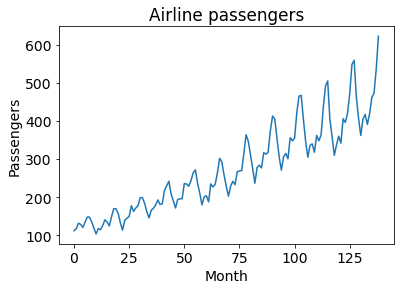

In [201]:
dataset = data.iloc[:,1].values
plt.plot(dataset)
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.title('Airline passengers')
plt.show()

### Построение модели

In [202]:
# Preprocessing
dataset = dataset.reshape(-1, 1)
dataset = dataset.astype('float32')
dataset.shape

(139, 1)

In [203]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [204]:
train_size = int(len(dataset)*0.54)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print(len(train),len(test))

75 64


In [205]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)
time_temp = 10
X_temp = []
Y_temp = []
for i in range(len(train)-time_temp-1):
    a = train[i:(i+time_temp), 0]
    X_temp.append(a)
    Y_temp.append(train[i + time_temp, 0])
X_train = np.array(X_temp)
y_train = np.array(Y_temp)  

In [206]:
X_temp = []
Y_temp = []
for i in range(len(test)-time_temp-1):
    a = test[i:(i+time_temp), 0]
    X_temp.append(a)
    Y_temp.append(test[i + time_temp, 0])
X_test = np.array(X_temp)
y_test = np.array(Y_temp)  

In [207]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Model

In [208]:
model = Sequential([
    LSTM(15, input_shape=(1,time_temp)),
    Dense(1)
])

In [209]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [210]:
%%time
model.fit(X_train, y_train, epochs=50, batch_size=1)

Epoch 1/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 2/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 3/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 4/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 5/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 6/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 7/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 8/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 9/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 10/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 11/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 12/50
64/64 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 13/50
64/64 [==============================

In [211]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.92 RMSE
Test Score: 36.84 RMSE


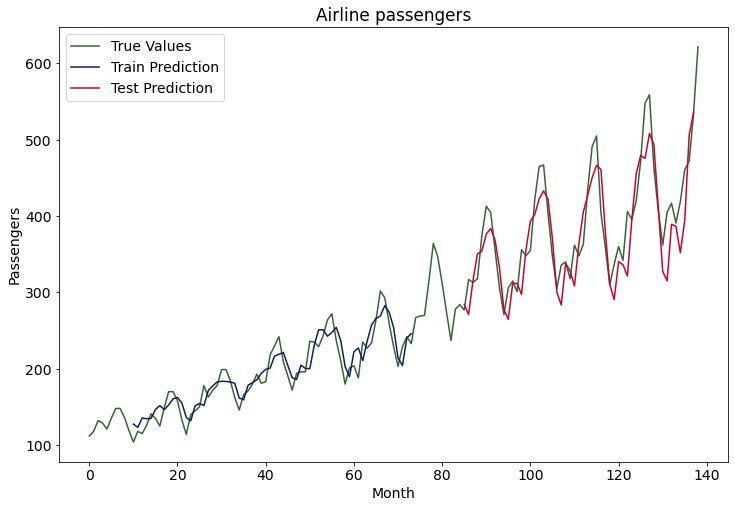

In [215]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_temp:len(trainPredict)+time_temp, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_temp*2)+1:len(dataset)-1, :] = testPredict

plt.figure(figsize = (12, 8))
plt.plot(scaler.inverse_transform(dataset), label = 'True Values', color='#336633')
plt.plot(trainPredictPlot, label='Train Prediction', color='#111d5e')
plt.plot(testPredictPlot, label = 'Test Prediction', color='#CC0033')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.title('Airline passengers')
plt.legend()
plt.savefig(fname = 'Results')
plt.show()

### Вывод:
В результате текущего практического задания, была реализована RNN(рекурентная нейронная сесть с LSTM). Прогноз временных рядов(Time series forecasting), для небольшого набора данных - 'Airline passengers' не идеален, но для обучения более, чем приемлем. Подбор размера выборки, а также параметров модели помогло улучшить точность.